In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401 (needed for 3D)
import os

In [18]:
def emissions_aviation_fuel():
    return 9.5  # kg CO2 per gallon

def emissions_saf():
    return 3.78  # kg CO2 per gallon

def revenue():
    return 9.7  # billion dollars

def operating_cost():
    return 5.66  # billion dollars without fuel

def fuel_qty():
    return 1.495  # billion gallons (fixed baseline per user)

def aviation_fuel_price(qty):
    # user asked to use fixed price form
    p = 2.10  # $/gallon
    return p

def saf_price(qty):
    p = 6.3  # $/gallon
    return p

In [23]:
def compute_profit_for_alpha(alpha, subsidy_per_gal, carbon_tax_per_ton):
    """
    alpha: SAF blend fraction in [0,1] (fraction of total fuel that is SAF)
    subsidy_per_gal: $/gal subsidy paid for SAF
    carbon_tax_per_ton: $/ton CO2
    Returns profit in billion $ and breakdown dict
    """
    # quantities in billion gallons
    q_total_b = fuel_qty()
    q_saf_b = q_total_b * alpha
    q_conv_b = q_total_b * (1.0 - alpha)

    # unit prices ($/gal)
    p_conv = aviation_fuel_price(q_conv_b)
    p_saf = saf_price(q_saf_b)

    # fuel cost in billion $
    fuel_cost_b = p_conv * q_conv_b + p_saf * q_saf_b

    # carbon tax: carbon_tax_billion = tau ($/ton) * emissions_kg_per_gal * qty_billion / 1000
    tau = carbon_tax_per_ton
    carbon_tax_conv_b = tau * emissions_aviation_fuel() * q_conv_b / 1000.0
    carbon_tax_saf_b = tau * emissions_saf() * q_saf_b / 1000.0
    carbon_tax_b = carbon_tax_conv_b + carbon_tax_saf_b

    # subsidy income in billion $ (applies only to SAF gallons)
    subsidy_income_b = subsidy_per_gal * q_saf_b

    # profit (billion $)
    profit_b = revenue() - operating_cost() - fuel_cost_b - carbon_tax_b + subsidy_income_b

    return profit_b, {
        'profit_billion': profit_b,
        'fuel_cost_billion': fuel_cost_b,
        'carbon_tax_billion': carbon_tax_b,
        'subsidy_income_billion': subsidy_income_b,
        'p_conv_per_gal': p_conv,
        'p_saf_per_gal': p_saf,
        'qty_conv_billion': q_conv_b,
        'qty_saf_billion': q_saf_b
    }

# -------------------------
# Surface generator & plotting
# -------------------------
def generate_profit_surface(alpha=0.0,
                            tau_min=0, tau_max=200, tau_steps=101,
                            s_min=0, s_max=4, s_steps=81,
                            save_csv_path='profit_surface.csv',
                            save_fig_path='profit_surface.png'):
    """
    Build grid over carbon tax (tau) and subsidy (s) and compute profit for given alpha.
    Produces a 3D surface and saves CSV + PNG.
    """
    tau_grid = np.linspace(tau_min, tau_max, tau_steps)     # $/ton
    s_grid = np.linspace(s_min, s_max, s_steps)             # $/gal

    TT, SS = np.meshgrid(tau_grid, s_grid, indexing='xy')   # SS rows=subsidy, TT cols=tau
    PROF = np.zeros_like(TT)

    # compute profits
    rows = []
    for i in range(SS.shape[0]):
        for j in range(TT.shape[1]):
            s = SS[i, j]
            tau = TT[i, j]
            profit_b, info = compute_profit_for_alpha(alpha, s, tau)
            PROF[i, j] = profit_b
            rows.append({
                'alpha': alpha,
                'subsidy_$per_gal': s,
                'tau_$per_ton': tau,
                'profit_billion': profit_b,
                'fuel_cost_billion': info['fuel_cost_billion'],
                'carbon_tax_billion': info['carbon_tax_billion'],
                'subsidy_income_billion': info['subsidy_income_billion'],
                'p_conv_per_gal': info['p_conv_per_gal'],
                'p_saf_per_gal': info['p_saf_per_gal'],
                'qty_conv_billion': info['qty_conv_billion'],
                'qty_saf_billion': info['qty_saf_billion']
            })


    # 3D surface plot
    fig = plt.figure(figsize=(11,7))
    ax = fig.add_subplot(111, projection='3d')
    # convert to 2D arrays for plotting
    X = TT     # tau
    Y = SS     # subsidy
    Z = PROF

    #surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', linewidth=0, antialiased=True)
    #ax.set_xlabel('Carbon price ($/ton CO2)')
    #ax.set_ylabel('Subsidy ($/gal, SAF)')
    #ax.set_zlabel('Profit (billion $)')
    #ax.set_title(f'Airline profit surface (alpha = {alpha:.3f})')

    #fig.colorbar(surf, shrink=0.6, aspect=12, label='Profit (billion $)')
    #plt.tight_layout()
    #plt.savefig(save_fig_path, dpi=200)
    #print(f"Saved figure to: {save_fig_path}")
    #plt.show()

    return (X, Y, Z)

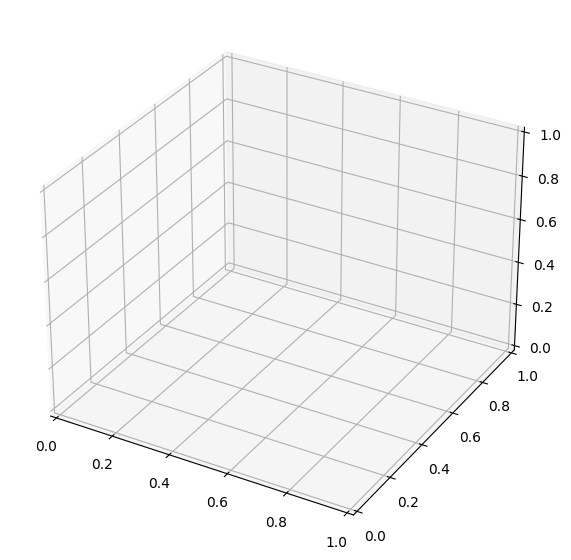

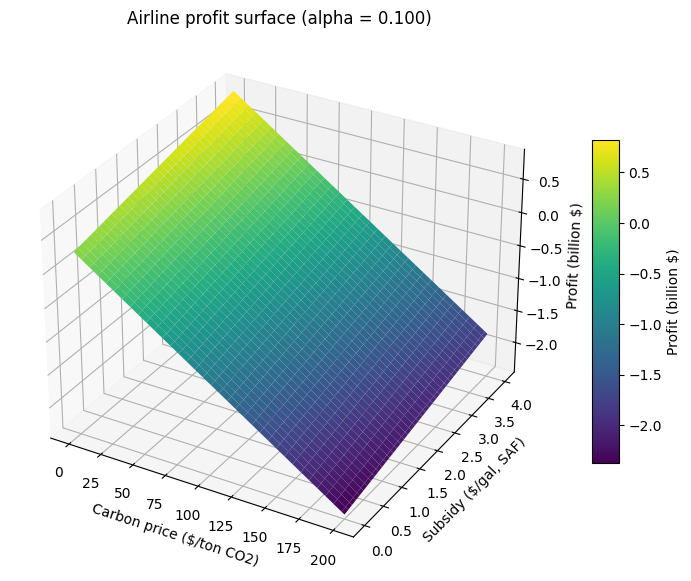

In [24]:
%matplotlib inline

if __name__ == '__main__':
    # Choose alpha here (0 = all conventional; 1 = all SAF; or any between)
    ALPHA = 0.1  # change this to test other blends
    out_csv = os.path.join('.', f'profit_surface_alpha_{ALPHA:.2f}.csv')
    out_png = os.path.join('.', f'profit_surface_alpha_{ALPHA:.2f}.png')

    X,Y,Z = generate_profit_surface(alpha=ALPHA,
                                   tau_min=0, tau_max=200, tau_steps=101,
                                   s_min=0, s_max=4, s_steps=81,
                                   save_csv_path=out_csv,
                                   save_fig_path=out_png)
        # 3D surface plot
    fig = plt.figure(figsize=(11,7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', linewidth=0, antialiased=True)
    ax.set_xlabel('Carbon price ($/ton CO2)')
    ax.set_ylabel('Subsidy ($/gal, SAF)')
    ax.set_zlabel('Profit (billion $)')
    ax.set_title(f'Airline profit surface (alpha = {ALPHA:.3f})')

    fig.colorbar(surf, shrink=0.6, aspect=12, label='Profit (billion $)')
